In [1]:
import bw2calc as bc
import bw2data as bd
import bw2io
from pathlib import Path
from bw2io.importers.ilcd import ILCDImporter
import pandas as pd
from IPython.display import display,Image
import textwrap
import numpy as np

In [2]:
bd.projects.set_current('brightcon2023_ilcd')
bw2io.bw2setup()

Creating default biosphere

Applying strategy: normalize_units
Applying strategy: drop_unspecified_subcategories
Applying strategy: ensure_categories_are_tuples
Applied 3 strategies in 0.01 seconds
Title: Writing activities to SQLite3 database:
  Started: 09/03/2023 20:11:04
  Finished: 09/03/2023 20:11:04
  Total time elapsed: 00:00:00
  CPU %: 99.80
  Memory %: 2.70
Created database: biosphere3
Creating default LCIA methods

Wrote 762 LCIA methods with 227223 characterization factors
Creating core data migrations



In [3]:
if 'sdk' in bd.databases:
    sdk_db = bd.Database('sdk')
    sdk_db.deregister()
    del sdk_db
    

In [4]:
bd.__version__ # problems with higher versions than dev18

(4, 0, 'DEV18')

In [25]:
gwp100 = ('IPCC 2021', 'climate change', 'global warming potential (GWP100)')
assert gwp100 in bd.methods

# A Brightway importer for the ILCD data exchange format

Sources of free ILCD files:
- [LCA Commons](https://www.lcacommons.gov/lca-collaboration/)
- [GLAD](https://www.globallcadataaccess.org/)

## 1) JRC test file 

for testing purposes the JRC provides a test file of the ilcd exchange data format that we'll use in first place [here](https://eplca.jrc.ec.europa.eu/LCDN/developerILCDDataFormat.xhtml). This test file includes some features that are not often available, like a definition of the product system model

In [11]:
path_to_example = Path('ilcd_examples/ILCD_sdk_211_simp.zip')
sdk = ILCDImporter(dirpath= path_to_example,dbname='sdk')
sdk.apply_strategies()
sdk.statistics()

Applying strategy: rename_activity_keys
Applying strategy: set_production_exchange
Applying strategy: convert_to_default_units
Applying strategy: set_activity_unit
Applying strategy: assign_only_product_as_production
Applying strategy: map_to_biosphere3
Applying strategy: set_default_location
Applying strategy: transform_uncertainty
Applying strategy: reformat_connexions
Applying strategy: set_connexions_based_on_psm
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: remove_clutter
Applied 13 strategies in 0.21 seconds
7 datasets
34 exchanges
20 unlinked exchanges
  Type biosphere: 3 unique unlinked exchanges
  Type technosphere: 4 unique unlinked exchanges


(7, 34, 20)

In [12]:
sdk.match_database('biosphere3',fields=['database','code','unit'],kind='biosphere')
sdk.statistics()

Applying strategy: link_iterable_by_fields
7 datasets
34 exchanges
7 unlinked exchanges
  Type technosphere: 4 unique unlinked exchanges


(7, 34, 7)

In [13]:
unlinked_df = pd.DataFrame(sdk.unlinked)

In [15]:
unlinked_df[['exchanges_name','exchanges_uuid','amount','type']]

,exchanges_name,exchanges_uuid,amount,type
0,Water (process water),0123d60d-1c78-4a38-9fa0-90b1b6c9491e,4.00000,technosphere
1,"Water (waste water, untreated)",4f1a3f41-7b3b-11dd-ad8b-0800200c9a66,4.00000,technosphere
2,Electricity high voltage,598e8a3b-c1e5-49d2-8305-176bfd0af3c2,0.00858,technosphere
3,Water (tap water),4f197bf2-7b3b-11dd-ad8b-0800200c9a66,0.39100,technosphere


from the file we can get an idea of what it was meant to be imported

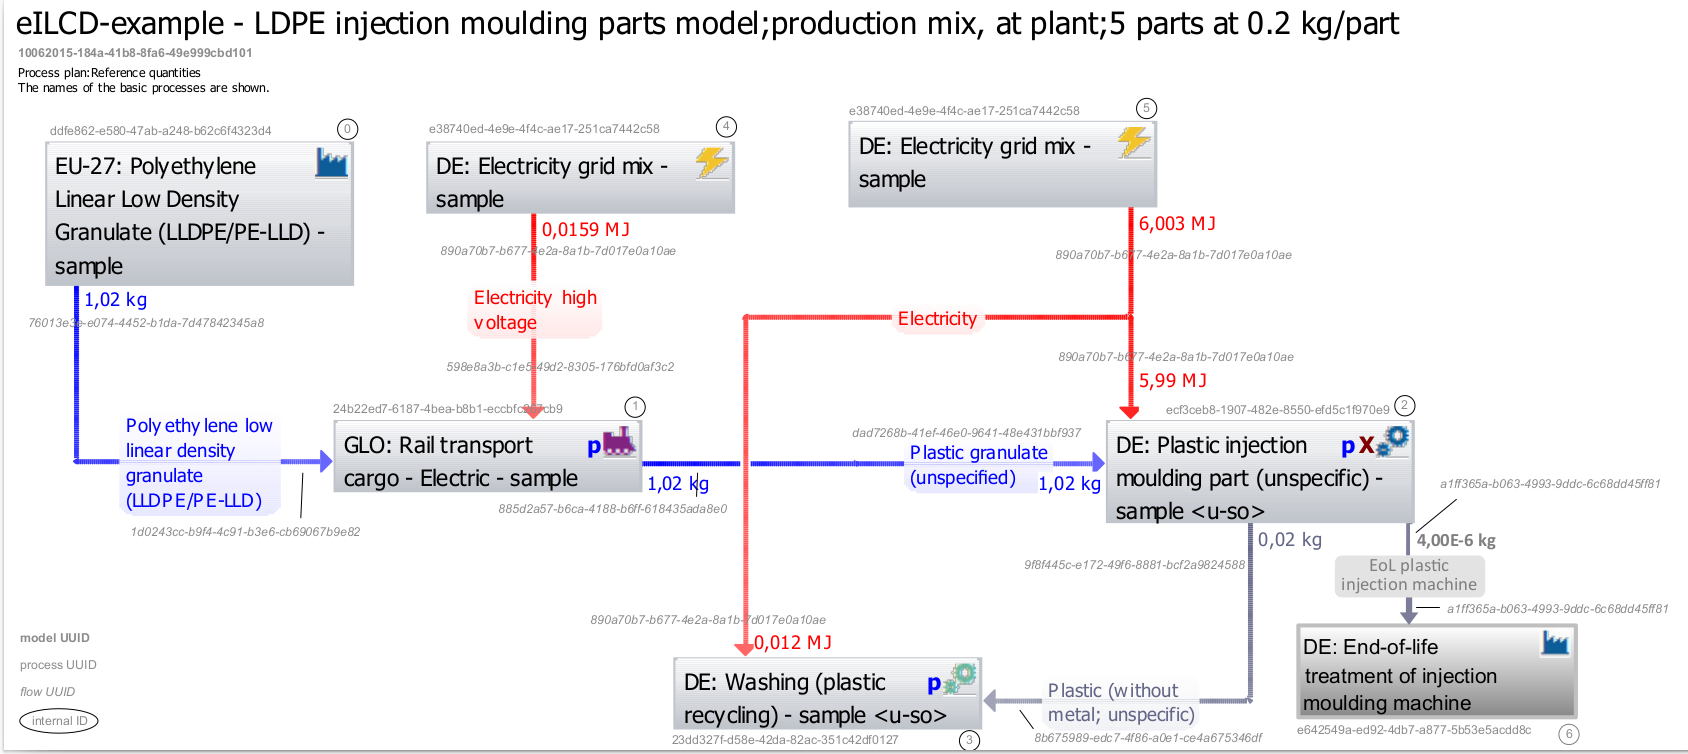

In [16]:
Image(filename='sdk_product_system_model.png',width=800)

In [17]:
sdk.drop_unlinked(True)

Applying strategy: drop_unlinked
Applied 1 strategies in 0.00 seconds


In [18]:
sdk.statistics()

7 datasets
27 exchanges
0 unlinked exchanges
  


(7, 27, 0)

In [19]:
sdk.write_database()

Not able to determine geocollections for all datasets. This database is not ready for regionalization.


Title: Writing activities to SQLite3 database:
  Started: 09/03/2023 20:21:53
  Finished: 09/03/2023 20:21:53
  Total time elapsed: 00:00:00
  CPU %: 0.00
  Memory %: 5.05
Created database: sdk


Brightway2 SQLiteBackend: sdk

In [20]:
sdk_db = bd.Database('sdk')

In [21]:
plastic_injection = bd.get_node(name='Plastic injection moulding part (unspecific) - sample')

In [28]:
lca = plastic_injection.lca(gwp100)

In [29]:
A = pd.DataFrame(lca.technosphere_matrix.todense())

# format A
cols = pd.MultiIndex.from_tuples([(bd.get_activity(key)['name'],
bd.get_activity(key)['location'] )for key in lca.activity_dict])

rows = pd.MultiIndex.from_tuples([(bd.get_activity(key)['name'],
bd.get_activity(key)['location'] )for key in lca.product_dict])
A.columns = cols
A.index = rows

In [30]:
B = pd.DataFrame(lca.biosphere_matrix.todense())
B_rows = pd.MultiIndex.from_tuples([(bd.get_activity(key)['name'],
bd.get_activity(key)['categories'] )for key in lca.biosphere_dict])
B.index =  B_rows
B.columns = cols

In [31]:
def style_negative(v, props=''):
    return props if v < 0 else None

In [32]:
A.style.highlight_max(axis=0).map(style_negative, props='color:red;')

,,Washing (plastic recycling) - sample,Rail transport cargo - Electric - sample,Polyethylene Linear Low Density Granulate (LLDPE/PE-LLD) - sample,eILCD-example - 5 parts at 0.2 kg/part,Electricity grid mix - sample,End-of-life treatment of injection moulding machine,Plastic injection moulding part (unspecific) - sample
,,DE,GLO,EU-27,DE,DE,DE,DE
Washing (plastic recycling) - sample,DE,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Rail transport cargo - Electric - sample,GLO,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-1.020000
Polyethylene Linear Low Density Granulate (LLDPE/PE-LLD) - sample,EU-27,0.000000,-1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
eILCD-example - 5 parts at 0.2 kg/part,DE,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
Electricity grid mix - sample,DE,-0.600000,0.000000,0.000000,0.000000,3.600000,0.000000,-4.642200
End-of-life treatment of injection moulding machine,DE,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
Plastic injection moulding part (unspecific) - sample,DE,-0.970000,0.000000,0.000000,0.000000,0.000000,0.000000,0.979996


In [33]:
B

,,Washing (plastic recycling) - sample,Rail transport cargo - Electric - sample,Polyethylene Linear Low Density Granulate (LLDPE/PE-LLD) - sample,eILCD-example - 5 parts at 0.2 kg/part,Electricity grid mix - sample,End-of-life treatment of injection moulding machine,Plastic injection moulding part (unspecific) - sample
,,DE,GLO,EU-27,DE,DE,DE,DE
"Carbon dioxide, fossil","(air,)",0.037208,0.0,1.572077,1.891965,0.172077,0.972077,0.0
"Carbon monoxide, fossil","(air,)",0.000066,0.0,0.004621,0.004985,0.000162,0.000362,0.0
"Energy, potential (in hydropower reservoir), converted","(natural resource, in water)",0.000000,0.0,60.155514,62.286789,0.555149,0.000000,0.0


In [34]:
AB = pd.concat([A,B])

Parameters

In [37]:
plastic_injection.as_dict().keys()

dict_keys(['treatment_standards_routes', 'mix_and_location_types', 'functional_unit_flow_properties', 'uuid', 'general_comment', 'reference_year', 'data_set_valid_until', 'time_representativeness_description', 'location', 'LatLong', 'intended_application', 'dataset_format', 'licensetype', 'parameters', 'contacts', 'connexions', 'database', 'type', 'code', 'name', 'unit', 'exchanges_name', 'reference product', 'production amount', 'id'])

In [41]:
plastic_injection['treatment_standards_routes']

In [46]:
pd.DataFrame(plastic_injection['parameters']).sample(axis=0).T

,0
parameter_name,CW
parameter_comment,[kg] Cooling water losses
parameter_mean_value,0.391
parameter_minimum_value,None
parameter_maximum_value,None
parameter_std95,0
parameter_formula,78.2 * weight * 0.005
parameter_distrib,None


In [35]:
pd.DataFrame(plastic_injection.exchanges()).dropna(how='all',axis=1).T

,0,1,2,3,4
amount,1.02,4.6422,0.02,1.0,0.000004
code,NaN,NaN,NaN,ecf3ceb8-1907-482e-8550-efd5c1f970e9,NaN
database,NaN,NaN,NaN,sdk,NaN
exchanges_name,Plastic granulate (unspecified),Electricity,Plastic (unspecified),Plastic part (unspecified),End-of-life injection moulding machine
exchanges_param_name,material,electricity,waste,weight,EoLmach
exchanges_uuid,dad7268b-41ef-46e0-9641-48e431bbf937,890a70b7-b677-4e2a-8a1b-7d017e0a10ae,9f8f445c-e172-49f6-8881-bcf2a9824588,336b1168-c3ea-4b5c-9955-beb577f3c005,a1ff365a-b063-4993-9ddc-6c68dd45ff81
flow property,Mass,Net calorific value,Mass,Mass,Mass
input,"(sdk, 24b22ed7-6187-4bea-b8b1-eccbfc267cb9)","(sdk, e38740ed-4e9e-4f4c-ae17-251ca7442c58)","(sdk, ecf3ceb8-1907-482e-8550-efd5c1f970e9)","(sdk, ecf3ceb8-1907-482e-8550-efd5c1f970e9)","(sdk, ecf3ceb8-1907-482e-8550-efd5c1f970e9)"
loc,1.02,4.6422,0.02,1.0,0.000004
name,Plastic granulate (unspecified),Electricity,Plastic (unspecified),Plastic part (unspecified),EoL plastic injection machine


## a random process from GLAD

feel free to pick a different one (https://www.globallcadataaccess.org/)

One of the complications of importing ILCD files is that the elementary flows almost always follow a different nomenclature that ecoinvent, the default list used in brightway (and the default impact assessment methods). So one often required step is to adjust the elementary flows. Luckly there are stablished mappings to help us:

- EF 3.0 -> ecoinvent 3.7 [link](https://github.com/UNEP-Economy-Division/GLAD-ElementaryFlowResources/tree/master/Mapping/Output/Mapped_files)
- FEDEFLv1.0.3 -> ecoinvent 3.7 [link](https://github.com/UNEP-Economy-Division/GLAD-ElementaryFlowResources/tree/master/Mapping/Output/Mapped_files)
- EF 2.0 -> EF 3.0 [link](https://eplca.jrc.ec.europa.eu/permalink/EF_3.0_Complete.zip)
- EF 1.1 -> EF 2.0 [link](https://eplca.jrc.ec.europa.eu/permalink/EF_2.0_Complete.zip)
- ecoinvent 3.7 -> ecoinvent 3.8 [link](https://github.com/Depart-de-Sentier/happy_family/tree/main/Elementary%20flow%20mapping/outputs)
- ecoinvent 3.8 -> ecoinvent 3.9 [link](https://github.com/Depart-de-Sentier/happy_family/tree/main/Elementary%20flow%20mapping/outputs)


if your dataset is defined using EF1.1 (a very common case in the datasets reported in GLAD) then these would need to be converted to whatever version of ecoinvent is being used to define the biosphere3 database

In [48]:
path_to_example = Path('ilcd_examples/plastics_europe_example.zip')
plastic_eu = ILCDImporter(dirpath= path_to_example,dbname='plastics_europe')
plastic_eu.apply_strategies()
plastic_eu.statistics()

Applying strategy: rename_activity_keys
Applying strategy: set_production_exchange
Applying strategy: convert_to_default_units
Applying strategy: set_activity_unit
Applying strategy: assign_only_product_as_production
Applying strategy: map_to_biosphere3
Applying strategy: set_default_location
Applying strategy: transform_uncertainty
Applying strategy: reformat_connexions
Applying strategy: set_connexions_based_on_psm
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: remove_clutter
Applied 13 strategies in 0.03 seconds
1 datasets
552 exchanges
551 unlinked exchanges
  Type biosphere: 316 unique unlinked exchanges


(1, 552, 551)

in the [documentation](https://plasticseurope.lca-data.com/datasetdetail/process.xhtml?uuid=b60b30bf-991d-41b8-a295-5d0b2e5f2bb5&version=09.00.000) we can see that it is in ilcd 1.1. 

In [49]:
mapping_df = pd.read_csv('ilcd11_ecoinvent37.csv').dropna()

In [50]:
mapping_dict = mapping_df.dropna().set_index('UUID OLD (ILCD 2016)').uuid_ecoinvent37.to_dict()

In [51]:
plastic_eu.data = bw2io.strategies.ilcd.alternative_map_to_biosphere3(plastic_eu.data,
mapping_dict)
plastic_eu.match_database('biosphere3',fields=['database','code','unit'])

Applying strategy: link_iterable_by_fields


In [53]:
plastic_eu.statistics()

1 datasets
552 exchanges
87 unlinked exchanges
  Type biosphere: 78 unique unlinked exchanges


(1, 552, 87)

substantially lower number of unlinked exchanges

In [54]:
plastic_eu.drop_unlinked(True)

Applying strategy: drop_unlinked
Applied 1 strategies in 0.00 seconds


In [55]:
plastic_eu.write_database()

Writing activities to SQLite3 database:


Not able to determine geocollections for all datasets. This database is not ready for regionalization.


0% [#] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 09/02/2023 22:27:20
  Finished: 09/02/2023 22:27:20
  Total time elapsed: 00:00:00
  CPU %: 101.40
  Memory %: 4.07
Created database: plastics_europe


Brightway2 SQLiteBackend: plastics_europe

In [58]:
plastics_eu_act = bd.Database('plastics_europe').random()

a quick tour of the information available

In [65]:
print(textwrap.fill(plastics_eu_act['general_comment'],120))

The main data source was a data collection from European producers of white and grey EPS. Primary data on gate-to-gate
EPS production is derived from site-specific information for processes under operational control supplied by the
participating companies of this eco-profile: ten white EPS beads producers with thirteen plants in nine different
European countries; four grey EPS producers with four plants in four European countries. This covers more than 80 % of
the European white and grey EPS beads production (EU-27) in 2013.


In [66]:
print(textwrap.fill(plastics_eu_act['intended_application'],120))

This background LCI data set can be used for any types of LCA studies. LCA studies considering the full life cycle
(»cradle-to-grave«) of an application or product allow for comparative assertions to be derived. It is essential to note
that comparisons cannot be made at the level of the polymer or its precursors. In order to compare the performance of
different materials, the whole life cycle and the effects of relevant life cycle parameters must be considered. It is
intended to be used by member companies, to support product-orientated environmental management; by users of plastics,
as a building block of life cycle assessment (LCA) studies of individual products; and by other interested parties, as a
source of life cycle information.


In [69]:
pd.DataFrame(plastics_eu_act['contacts'])

,email,website,short_name
0,None,None,DEKRA Assurance Services GmbH
1,info@plasticseurope.org,http://www.plasticseurope.org,Plastics Europe
2,info@thinkstep.com,http://www.thinkstep.com,thinkstep
3,unep.tie@unep.org,www.lcinitiative.unep.fr,UNEP SETAC Life Cycle Initiative
4,None,None,No official approval by producer or operator
5,LCA@JRC.it,http://lca.jrc.ec.europa.eu,EPLCA project team
6,matthias.schulz@dekra.com,None,Matthias Schulz
7,IES-contact@jrc.ec.europa.eu,http://ies.jrc.ec.europa.eu,European Commission - JRC directorate D
8,jrc-info@ec.europa.eu,www.jrc.ec.europa.eu/,JRC
9,info@thinkstep.com,http://www.thinkstep.com,thinkstep


In [78]:
pd.DataFrame(plastics_eu_act.exchanges()).sample(3).T

,56,296,332
CAS number,007440-31-5,007439-96-5,010102-43-9
amount,0.0,0.0,0.00001
category_0,Resources,Emissions,Emissions
category_1,Resources from ground,Emissions to water,Emissions to air
category_2,Non-renewable element resources from ground,Emissions to sea water,"Emissions to air, unspecified"
code,53d5ef26-66d8-4536-afa2-2f6b114189ba,c91fd4bf-ed70-4e2f-a34f-159773f981b6,17f7e776-7934-54af-8c3c-ed0247cb697b
database,biosphere3,biosphere3,biosphere3
exchanges_name,tin (Non-renewable element resources from ground),manganese (Emissions to sea water),"nitrogen monoxide (Emissions to air, unspecified)"
exchanges_param_name,None,None,None
exchanges_uuid,29068976-6556-11dd-ad8b-0800200c9a66,fe0acd60-3ddc-11dd-af15-0050c2490048,08a91e70-3ddc-11dd-96ee-0050c2490048


In [80]:
plastics_eu_act.as_dict().keys()

dict_keys(['treatment_standards_routes', 'mix_and_location_types', 'functional_unit_flow_properties', 'uuid', 'general_comment', 'reference_year', 'data_set_valid_until', 'time_representativeness_description', 'location', 'LatLong', 'intended_application', 'dataset_format', 'licensetype', 'parameters', 'contacts', 'database', 'type', 'code', 'name', 'unit', 'exchanges_name', 'reference product', 'production amount', 'id'])

In [71]:
plastics_lca = plastics_eu_act.lca(gwp100)

In [73]:
plastics_lca.to_dataframe()

,row_index,col_index,amount,row_id,col_id,row_database,row_code,row_name,row_location,row_unit,row_type,row_categories,row_product,col_database,col_code,col_name,col_location,col_unit,col_type,col_reference_product
0,45,0,2.144233e+00,1229,4435,biosphere3,349b29d1-3e58-4c66-98b9-9d1a076efd2e,"Carbon dioxide, fossil",None,kilogram,emission,air,None,plastics_europe,b60b30bf-991d-41b8-a295-5d0b2e5f2bb5,"Expandable polystyrene (EPS), white and grey",EU-27,kilogram,process,"Expandable polystyrene (EPS), white and grey"
1,105,0,2.415771e-01,1737,4435,biosphere3,0795345f-c7ae-410c-ad25-1845784c75f5,"Methane, fossil",None,kilogram,emission,air,None,plastics_europe,b60b30bf-991d-41b8-a295-5d0b2e5f2bb5,"Expandable polystyrene (EPS), white and grey",EU-27,kilogram,process,"Expandable polystyrene (EPS), white and grey"
2,63,0,9.990277e-03,1373,4435,biosphere3,20185046-64bb-4c09-a8e7-e8a9e144ca98,Dinitrogen monoxide,None,kilogram,emission,air,None,plastics_europe,b60b30bf-991d-41b8-a295-5d0b2e5f2bb5,"Expandable polystyrene (EPS), white and grey",EU-27,kilogram,process,"Expandable polystyrene (EPS), white and grey"
3,47,0,5.038893e-03,1241,4435,biosphere3,ba2f3f82-c93a-47a5-822a-37ec97495275,"Carbon monoxide, fossil",None,kilogram,emission,air,None,plastics_europe,b60b30bf-991d-41b8-a295-5d0b2e5f2bb5,"Expandable polystyrene (EPS), white and grey",EU-27,kilogram,process,"Expandable polystyrene (EPS), white and grey"
4,404,0,-1.121521e-04,4036,4435,biosphere3,17f7e776-7934-54af-8c3c-ed0247cb697b,Nitric oxide,None,kilogram,emission,air,None,plastics_europe,b60b30bf-991d-41b8-a295-5d0b2e5f2bb5,"Expandable polystyrene (EPS), white and grey",EU-27,kilogram,process,"Expandable polystyrene (EPS), white and grey"
5,406,0,2.341670e-05,4061,4435,biosphere3,4ec70203-13b0-58cc-b4dd-2fcce8a96732,"VOC, volatile organic compounds, unspecified o...",None,kilogram,emission,air,None,plastics_europe,b60b30bf-991d-41b8-a295-5d0b2e5f2bb5,"Expandable polystyrene (EPS), white and grey",EU-27,kilogram,process,"Expandable polystyrene (EPS), white and grey"
6,109,0,3.251732e-06,1757,4435,biosphere3,e5ba3517-a93f-422e-9ce2-f1007fcf6c06,"Methane, trifluoro-, HFC-23",None,kilogram,emission,air,None,plastics_europe,b60b30bf-991d-41b8-a295-5d0b2e5f2bb5,"Expandable polystyrene (EPS), white and grey",EU-27,kilogram,process,"Expandable polystyrene (EPS), white and grey"
7,107,0,2.597159e-06,1749,4435,biosphere3,33681770-a0e1-4ce8-93c3-941fd607fa5f,"Methane, tetrafluoro-, R-14",None,kilogram,emission,air,None,plastics_europe,b60b30bf-991d-41b8-a295-5d0b2e5f2bb5,"Expandable polystyrene (EPS), white and grey",EU-27,kilogram,process,"Expandable polystyrene (EPS), white and grey"
8,70,0,1.675606e-06,1429,4435,biosphere3,8a3a44e4-e2f1-476d-9e9e-a90fda263fe3,"Ethane, 1,2-dichloro-1,1,2,2-tetrafluoro-, CFC...",None,kilogram,emission,air,None,plastics_europe,b60b30bf-991d-41b8-a295-5d0b2e5f2bb5,"Expandable polystyrene (EPS), white and grey",EU-27,kilogram,process,"Expandable polystyrene (EPS), white and grey"
9,72,0,4.017606e-07,1449,4435,biosphere3,acc39720-dda7-4b3a-80c7-c6394cad4191,"Ethane, hexafluoro-, HFC-116",None,kilogram,emission,air,None,plastics_europe,b60b30bf-991d-41b8-a295-5d0b2e5f2bb5,"Expandable polystyrene (EPS), white and grey",EU-27,kilogram,process,"Expandable polystyrene (EPS), white and grey"
